Data mining Project 1

Bilal Akdidach - s1107332

Arif Erdogan - s1105708

# Introduction

In this data mining project we will be looking at 3 data mining algorithms below, all part of classification algorithms. With the algorithms we try to solve a problem regarding private insurer companies that want to make as much profit as possible. This can be done by labeling people based on earlier expenses and or health statistics into categories being 'Low Risk' and 'High Risk'

# Data exploration
We have found a large dataset spread out over 3 smaller datasets. They seem to be categorized data.
We will use manual data exploration, by just checking and searching through the 3 datasets that we got.

Important to note is that the source we got the datasets from gave us 3 seperate datasets instead of all data in 1 singular file, hence we must merge rows of all 3 files based on the patient id, and then add the columns together in the same patient row.

One dataset, called the hospitalizations was a dataset that contained the medical charges that a certain person had to make on a certain date, in what city, what type of hospital, how many children they got etc. It's basically all information of a patient's visit at the hospital.

The second dataset called medical examinations contains lots of columns that have to do with the health of the patient, so you can think about bmi, heart diseases, transplants, cancer history, smoker etc etc. So this dataset basically contains all information about the health of a patient.

The last dataset was a set containing only the patient id and the name of the patient.

What we need to do in the pre-visualization step as said above, is import all 3 csv files and merge all their columns together based on matching patient ids (which is the first column of all 3 files, denoted by ID + patient number). By doing that we get one big dataset containing all required columns of a patient.

Not only that but because of this fast exploration, we also found lots of missing values (" ", which is transported into '?' by excel). This can have various reason like the file going corrupt, or people not wanting to give answers on these questions etc.
Hence, in our data pre-processing step we most likely need to remove all rows that contain such undefined values.


# Data pre-visualization

# 1

In [1]:
import pandas as pd
import numpy as np

# Now we will pre-process the datasets by removing rows that have a missting Customer ID 
# such that these rows cannot be matched with rows from the other sets.
hospitalizations = pd.read_csv('Hospitalizations.csv')
medicals = pd.read_csv('Medical Examinations.csv')
names = pd.read_csv('Names.csv', sep= ';')
hospitalizations = hospitalizations[hospitalizations['Customer ID'] != "?"]
medicals = medicals[medicals['Customer ID'] != "?"]
names = names[names['Customer ID'] != "?"]

# 2

In [2]:
# now we will merge all data in the files by customer id.
firstMerge = pd.merge(hospitalizations, medicals, on='Customer ID', how='outer')
secondMerge = pd.merge(names, firstMerge, on='Customer ID', how='outer')
# now we are printing all missing values and replacing the missing values with a NaN value such that we can drop
# the rows using dropna()
print("Missing values:\n", secondMerge.isna().sum(), "\n\n")
secondMerge.replace('?', np.nan, inplace=True)
secondMerge = secondMerge.dropna()
print(secondMerge)

Missing values:
 Customer ID               0
name                      2
year                      0
month                     0
date                      0
children                  0
charges                   0
Hospital tier             0
City tier                 0
State ID                  0
BMI                       2
HBA1C                     2
Heart Issues              2
Any Transplants           2
Cancer history            2
NumberOfMajorSurgeries    2
smoker                    2
dtype: int64 


     Customer ID                                name  year month  date  \
0            Id1                   Hawks, Ms.  Kelly  1968   Oct    12   
1            Id2              Lehner, Mr.  Matthew D  1977   Jun     8   
3            Id4                Osborne, Ms.  Kelsey  1991   Jun     6   
4            Id5                Kadala, Ms.  Kristyn  1989   Jun    19   
5            Id6              Baker, Mr.  Russell B.  1962   Aug     4   
...          ...                               

Now we have successfully reduced the amount of rows from the different datasets by removing rows that had undefined values.
We now also have successfully added the 3 different datasets into 1 dataset, by matching the Customer ID variable of all 3 files.

# Data Visualization + Preprocessing

We remove the columns customer id and name as they have a gini of 1 and are most likely not going to be used in our decision tree. We are leaving the rest like it is, and let the decision tree make splits based off the gini's of each variable.
    

# 3

In [3]:
# we drop columns that have a gini of 1 and therefore don't matter to us
columns_to_drop = ['Customer ID', 'name']
secondMerge.drop(columns=columns_to_drop, inplace=True)

# 4

In [4]:
# we now make 2 of our variables that contain either a number or a non-numerical value to a numerical value
# as these values can contain numbers we want to check whether we have outliers in these values.
secondMerge['NumberOfMajorSurgeries'] = pd.to_numeric(secondMerge['NumberOfMajorSurgeries'], errors='coerce').fillna(0).astype(int)
secondMerge['year'] = pd.to_numeric(secondMerge['year'], errors='coerce').fillna(0).astype(int)
secondMerge = secondMerge.values
print(secondMerge)

[[1968 'Oct' 12 ... 'No' 0 'yes']
 [1977 'Jun' 8 ... 'No' 0 'yes']
 [1991 'Jun' 6 ... 'No' 0 'yes']
 ...
 [1993 'Jun' 30 ... 'Yes' 1 'No']
 [1992 'Nov' 30 ... 'No' 1 'No']
 [1992 'Jul' 9 ... 'No' 1 'No']]


We know loop over all the variables that can have Numerical values and show a boxplot and a histogram of their distribution, as those are the only values that can have 
real outliers as nominal and ordinal values usually do not give outliers (they are just categorical).

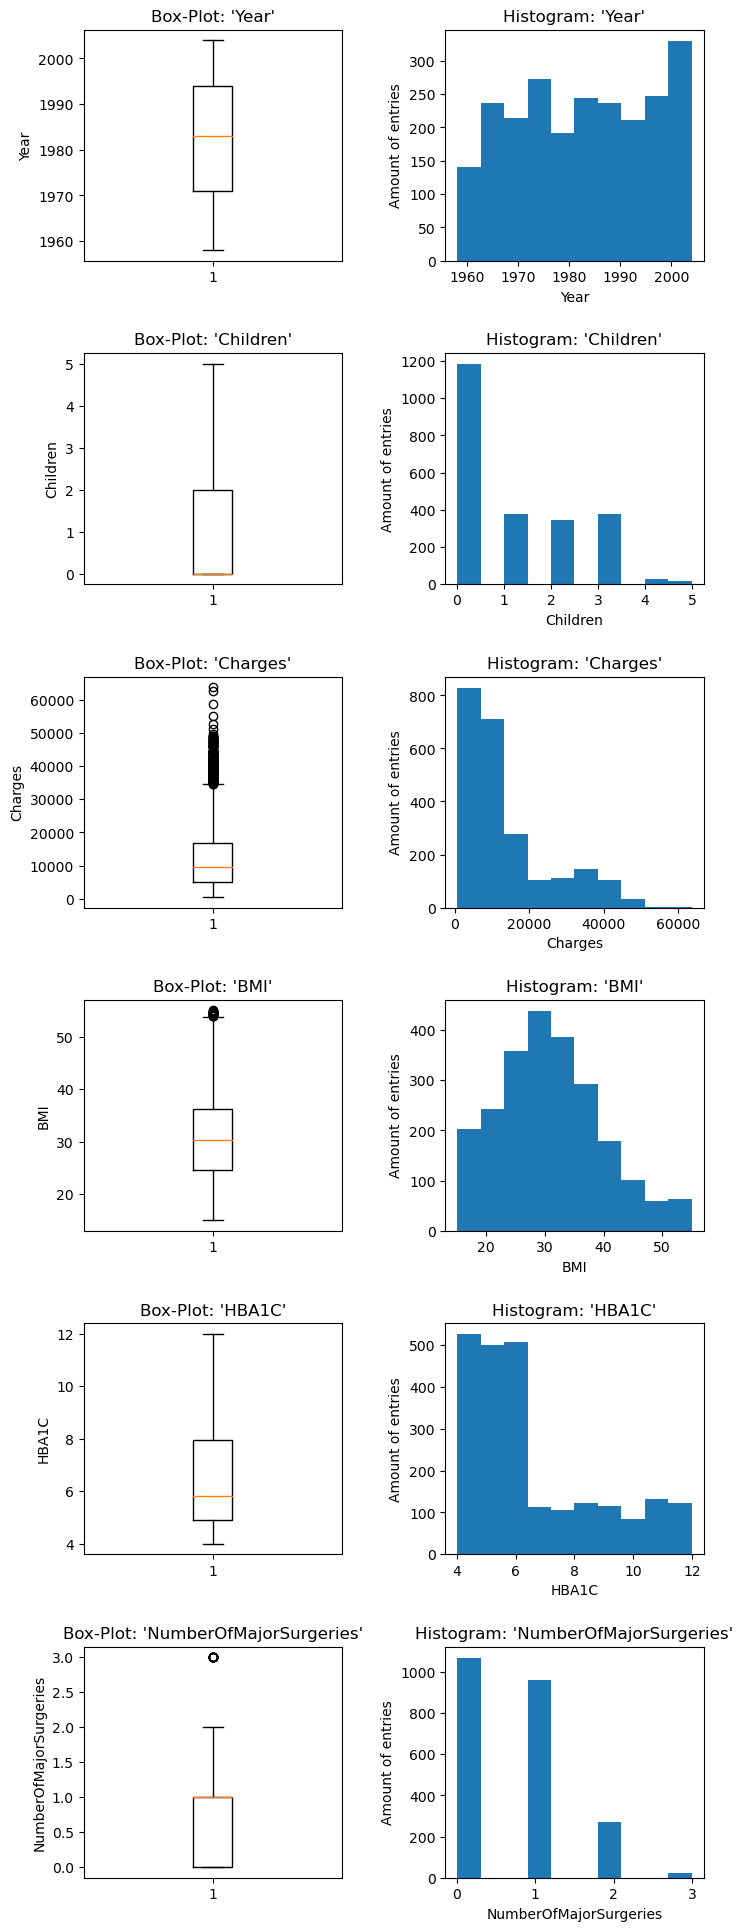

In [5]:
import matplotlib.pyplot as plt
f, arr = plt.subplots(6,2, figsize=(8, 24))
plt.subplots_adjust(wspace=0.4, hspace=0.4) 
indexes = [0, 3, 4, 8, 9, 13]
labels = ["Year",  "Children",  "Charges",  "BMI", "HBA1C", "NumberOfMajorSurgeries"  
]

for i in range(0,6):
    attribute = secondMerge[:, indexes[i]]
    arr[i, 0].boxplot(attribute)
    arr[i, 0].set_title("Box-Plot: " + "'" + labels[i] + "'")
    arr[i, 0].set_ylabel(labels[i])
    arr[i, 1].set_xlabel(labels[i])
    arr[i, 1].set_ylabel("Amount of entries")
    arr[i, 1].hist(attribute)
    arr[i, 1].set_title("Histogram: " + "'" + labels[i] + "'")


So we have 3 variables with outliers:
    numberofmajorsurgeries, charges and BMI.
    We don't really want to remove all the outliers as we are scared
    that the model won't be able to evaluate and work with extreme low/high values.
    Hence we will use the iqr to detect elements outside the box, and 
    then define the lower and upper bound of the iqr which is 1.5x the 1st and 3rd quartile.
    We will then create a predicate and loop over the 3 elements which had outliers to remove them if they are not within the lower/upper bound of the iqr.

# 5

In [6]:
# for the 3 variables that had outliers, we will try to filter out all elements that are outside the upper/lower bounds
for i in range(3):
    attribute = secondMerge[:, indexes[i]]
    Q1 = np.percentile(attribute, 25)
    Q3 = np.percentile(attribute, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (attribute < lower_bound) | (attribute > upper_bound)
    secondMerge = secondMerge[~outliers]
print(len(secondMerge))

2092


Now we will transform the output column (in our case charges) that we want to predict from numerical to a binary label by using thresholds to define the charges into low risk and high risk.
For this we use the median. The median shows the actual middle value of the whole dataset. We deliberately not use the mean as our dataset is really imbalanced and we would love to make it a bit more balanced, as well as we are looking for 2 labels instead of a multi-split variable.

# 6

In [7]:
# we create a charges_immutable variable for the charges column used in method 2
charges_immutable = secondMerge[:, 4]
# we then get the median of the dataset and transform the numerical charges to binary categories.
median_charge = np.median(secondMerge[:, 4])
print("The median of charge\n", median_charge, "\n")
for i in range(0, len(secondMerge[:, 4])):
    entry = secondMerge[i, 4]
    if(entry > median_charge): 
        secondMerge[i, 4] = 'High Risk'
    else:
        secondMerge[i, 4] = 'Low Risk'
print(secondMerge[:, 4])

The median of charge
 8562.08 

['High Risk' 'High Risk' 'High Risk' ... 'Low Risk' 'Low Risk' 'Low Risk']


We now must also encode all other Non-numerical data, as decision trees of sklearn only allow numerical data. For this we are using a OneHotEncoder, which basically creates a column for each possible combination.

# 7

In [8]:
from sklearn.preprocessing import OneHotEncoder
columns =  ['year', 'month', 'date', 'children', 'charges', 'hospital tier', 'city tier', 'state id', 'bmi', 'hba1c', 'heart issues', 'any transplants', 'cancer history', 'number of major surgeries', 'smoker']
df = pd.DataFrame(secondMerge, columns = columns)
categorical_columns = ['month', 'hospital tier', 'city tier', 'state id', 'heart issues', 'any transplants', 'cancer history', 'smoker']
encoder = OneHotEncoder(drop='first', sparse_output = False) # here we transform all above given numerical values 
encodedData = encoder.fit_transform(df[categorical_columns])
encodedColumnNames = encoder.get_feature_names_out(categorical_columns)
FinalSecondMerge = pd.concat([df.drop(categorical_columns, axis=1),
                                   pd.DataFrame(encodedData, columns=encodedColumnNames)],
                                  axis=1)
# we then in the step above get all the created feature names that it created for us 
# (one feature name for each combination of that variable), we then concat the two data frames together into one.
                
print(FinalSecondMerge)
print(encodedColumnNames)

      year date children    charges    bmi hba1c number of major surgeries  \
0     1976   25        2  High Risk  31.92  5.33                         0   
1     1998   24        0  High Risk   32.7  4.09                         1   
2     1990   24        3  High Risk  41.25  5.19                         0   
3     2003    5        0  High Risk  33.11  4.12                         1   
4     1984    1        3  High Risk  36.16   5.1                         1   
...    ...  ...      ...        ...    ...   ...                       ...   
2087  1998   27        0   Low Risk  22.34  5.57                         1   
2088  1992   13        0   Low Risk   17.7  6.28                         1   
2089  1993   30        0   Low Risk  16.47  6.35                         1   
2090  1992   30        0   Low Risk   17.6  4.39                         1   
2091  1992    9        0   Low Risk  17.58  4.51                         1   

      month_Dec  month_Jul  month_Jun  ...  state id_R1021  sta

Now as you can see, we have lots of numerical data that is very differing in scales. Hence it is best to use normalization and normalize the numbers to fall in between ranges of [-1,1] such that our model can work better with the given values and give each variable a fair chance in the model.

# 8

In [9]:
from sklearn import preprocessing
# we first split the column charges from our dataset, as that's the column we try to predict.
charges_column = FinalSecondMerge['charges']
data_to_scale = FinalSecondMerge.drop('charges', axis=1)  
# we then scale the rest of our dataset using the sklearn scaler into values of -1 and 1
scaled_data = preprocessing.scale(data_to_scale)
print(scaled_data)
print(charges_column)


[[-0.53836179  1.08150728  0.78748312 ... -0.26160501 -0.45284559
   2.67803566]
 [ 1.10340622  0.96672881 -0.82132028 ... -0.26160501 -0.45284559
   2.67803566]
 [ 0.50639968  0.96672881  1.59188482 ... -0.26160501 -0.45284559
   2.67803566]
 ...
 [ 0.73027713  1.65539964 -0.82132028 ... -0.26160501  2.20825825
  -0.37340802]
 [ 0.65565131  1.65539964 -0.82132028 ... -0.26160501 -0.45284559
  -0.37340802]
 [ 0.65565131 -0.75494827 -0.82132028 ... -0.26160501 -0.45284559
  -0.37340802]]
0       High Risk
1       High Risk
2       High Risk
3       High Risk
4       High Risk
          ...    
2087     Low Risk
2088     Low Risk
2089     Low Risk
2090     Low Risk
2091     Low Risk
Name: charges, Length: 2092, dtype: object


# 9

# Model TRAINING 

In [10]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# we first initialize the random state, the columns in our dataset that we want to use in the tree as well as
# the test and train errors that are appended after each depth
# and in each depth we are appending the test and train error of each iteration.
columns = ['year', 'month', 'date', 'children', 'hospital tier', 'city tier', 'state id', 'bmi', 'hba1c', 'heart issues', 'any transplants', 'cancer history', 'number of major surgeries', 'smoker']
random_state = 1337
train_errors = []
test_errors = []
depth_errors = 999999
best_depth_index = 0
# we then use a normal 2/3 split for training and testing, and we reserve 1/3 of our data for evaluation. 
# We stratify based on y to maintain our data distribution
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    scaled_data, charges_column, test_size=0.33, random_state=random_state, stratify = charges_column)

stratified_kfold = StratifiedKFold(n_splits=100, shuffle=True, random_state=random_state)
depths = list(range(2, 21))
# we are using a nested for loop as we are looping this over multiple depths to optimize the hyperparameters.
for depth in depths:
    train_errors_depth = []
    test_errors_depth = []
    # we then use stratified 100-fold cross validation to create 100 groups to test our data and train our data on.
    for train_index, test_index in stratified_kfold.split(X_train_full, y_train_full):
        X_train, X_test = scaled_data[train_index], scaled_data[test_index]
        y_train, y_test = charges_column[train_index], charges_column[test_index]
        rfc = RandomForestClassifier(max_depth=depth, criterion='gini', min_samples_split=100)
        # we fit our model and predict the results
        rfc.fit(X_train, y_train)

        y_train_pred = rfc.predict(X_train)
        y_test_pred = rfc.predict(X_test)
        # we append the current iteration scores to the train and test_errors_depth
        accuracyTrain = accuracy_score(y_train, y_train_pred)
        accuracyTest = accuracy_score(y_test, y_test_pred)

        errorTrain = 1 - accuracyTrain
        errorTest = 1 - accuracyTest

        train_errors_depth.append(errorTrain)
        test_errors_depth.append(errorTest)
    # we then append the mean of the whole depth to the total train and test errors.
    # Eventually we compare whether the current depth error is smaller than the error that was previously set.
    # if that is the case we are setting the current depth as the "best" depth.
    train_errors.append(np.mean(train_errors_depth))
    test_errors.append(np.mean(test_errors_depth))
    if(np.mean(train_errors_depth) + np.mean(test_errors_depth) < depth_errors):
        best_depth_index = depth
        depth_errors = np.mean(train_errors_depth) + np.mean(test_errors_depth)
    print("Depth", depth)
    print("Train data accuracy", 1 - np.mean(train_errors_depth))
    print("Test data accuracy", 1 - np.mean(test_errors_depth), "\n")
    

print("Best depth", best_depth_index)
print(y_test)

Depth 2
Train data accuracy 0.746609565632637
Test data accuracy 0.7466190476190476 

Depth 3
Train data accuracy 0.747626148184908
Test data accuracy 0.7466190476190476 

Depth 4
Train data accuracy 0.767756002709139
Test data accuracy 0.7609047619047619 

Depth 5
Train data accuracy 0.7985421992091062
Test data accuracy 0.7851904761904762 

Depth 6
Train data accuracy 0.8346994405898516
Test data accuracy 0.8016190476190477 

Depth 7
Train data accuracy 0.8634021177892843
Test data accuracy 0.8337142857142857 

Depth 8
Train data accuracy 0.873885143535468
Test data accuracy 0.8372857142857143 

Depth 9
Train data accuracy 0.8767186178397426
Test data accuracy 0.8495238095238096 

Depth 10
Train data accuracy 0.8784561341086214
Test data accuracy 0.8459047619047619 

Depth 11
Train data accuracy 0.8803812769782489
Test data accuracy 0.853047619047619 

Depth 12
Train data accuracy 0.8786724438743184
Test data accuracy 0.843047619047619 

Depth 13
Train data accuracy 0.879443924256469

# 10

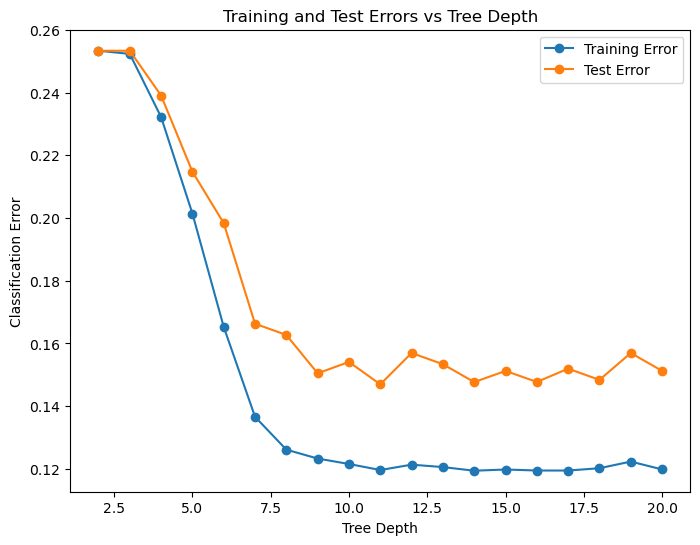

In [11]:
# We now print the test vs training errors given the depth.
plt.figure(figsize=(8, 6))
plt.plot(depths, train_errors, label='Training Error', marker='o')
plt.plot(depths, test_errors, label='Test Error', marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Classification Error')
plt.legend()
plt.title('Training and Test Errors vs Tree Depth')
plt.show()

# 11

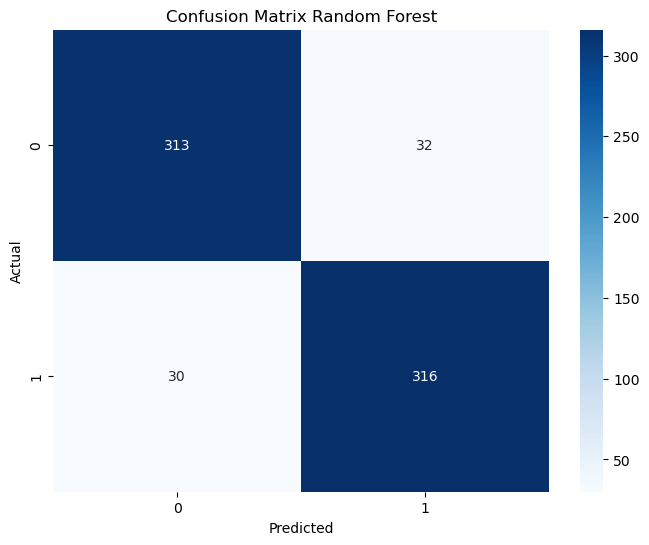

In [12]:
import seaborn as sns
# we first create the random forest classifier with the best hyperparameters we found and then fit it on our 
# non-used data that we split in the beginning
best_depth_classifier = RandomForestClassifier(max_depth=best_depth_index, criterion='gini', min_samples_split=100)
best_depth_classifier.fit(X_train_full, y_train_full)  
y_test_pred_rfc = best_depth_classifier.predict(X_test_full)
x_rfc = y_test_full
# we then create the confusion matrix given the real labels and predictions and show it.
conf_matrix_rfc = confusion_matrix(y_test_full, y_test_pred_rfc)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rfc, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Random Forest')
plt.show()

# 12

# Method 2

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# we once again define all variables and create a 2/3 split of the data
random_state = 1337
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    scaled_data, charges_immutable, test_size=0.33, random_state=random_state, stratify = charges_column)
stratified_kfold = StratifiedKFold(n_splits=100, shuffle=True, random_state=random_state)
log_reg = LogisticRegression()
train_errors = []
test_errors = []

# we once again create 100-folds of our data and fit our model on that data.
for train_index, test_index in stratified_kfold.split(X_train_full, y_train_full):
    X_train, X_test = scaled_data[train_index], scaled_data[test_index]
    y_train, y_test = charges_immutable[train_index], charges_immutable[test_index]

    log_reg.fit(X_train, y_train)

    y_train_pred = log_reg.predict(X_train)
    y_test_pred = log_reg.predict(X_test) 
    # we again calculate the accuracy of both test as train sets and apend it to the list
    accuracyTrain = accuracy_score(y_train, y_train_pred)
    accuracyTest = accuracy_score(y_test, y_test_pred)

    errorTrain = 1 - accuracyTrain
    errorTest = 1 - accuracyTest

    train_errors.append(errorTrain)
    test_errors.append(errorTest)

print("Train data accuracy:", 1 - np.mean(train_errors))
print("Test data accuracy:", 1 - np.mean(test_errors))




Train data accuracy: 0.8760265129407162
Test data accuracy: 0.8622380952380952


# 13

Confusion Matrix Random Forest


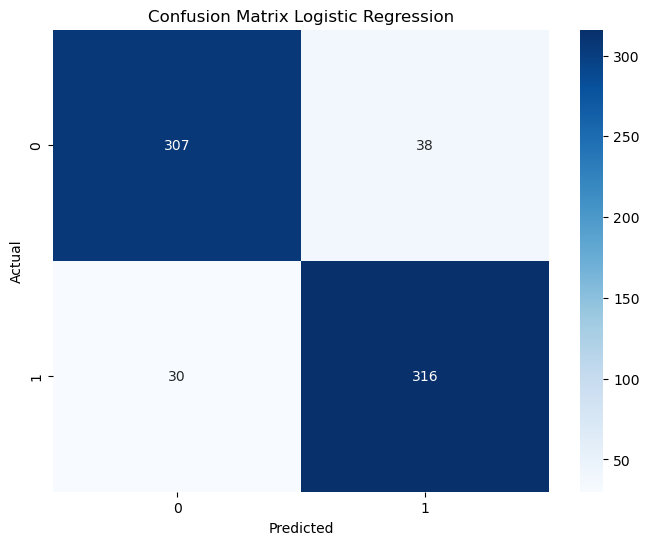

In [14]:
# we again create a logistic regression classifier and predict our data on the set (1/3 of total) we kept out
log_reg = LogisticRegression()
log_reg.fit(X_train_full, y_train_full)  
y_test_pred_log_reg = log_reg.predict(X_test_full)
x_logistic = y_test_full
# we then again create the confusion matrix given the predictions and real data.
conf_matrix_logistic = confusion_matrix(y_test_full, y_test_pred_log_reg)
print("Confusion Matrix Random Forest")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logistic, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Logistic Regression')
plt.show()


# method 3

# 14

In [15]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
# we again create all variables and create an evaluation split of our data
columns = ['year', 'month', 'date', 'children', 'hospital tier', 'city tier', 'state id', 'bmi', 'hba1c', 'heart issues', 'any transplants', 'cancer history', 'number of major surgeries', 'smoker']
random_state = 1337
train_errors = []
test_errors = []
conf_matrices = [] 
depth_errors = 999999
best_depth_index = 0
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    scaled_data, charges_column, test_size=0.33, random_state=random_state, stratify = charges_column)
stratified_kfold = StratifiedKFold(n_splits=100, shuffle=True, random_state=random_state)
depths = list(range(2, 21))
# as this is a decision tree, we can optimize depth hence we introduced an extra for loop again to tune
# hyperparameters. Hence we are also using 2 lists, one that appends the mean of all errors found in the depth
# one that appends all errors in the iterations of that depth.
for depth in depths:
    train_errors_depth = []
    test_errors_depth = []
    conf_matrices_depth = []  
    
    for train_index, test_index in stratified_kfold.split(X_train_full, y_train_full):
        X_train, X_test = scaled_data[train_index], scaled_data[test_index]
        y_train, y_test = charges_column[train_index], charges_column[test_index]
        dtc = DecisionTreeClassifier(max_depth=depth, criterion='gini', min_samples_split=100)
       
        dtc.fit(X_train, y_train)

        y_train_pred = dtc.predict(X_train)
        y_test_pred = dtc.predict(X_test)

        accuracyTrain = accuracy_score(y_train, y_train_pred)
        accuracyTest = accuracy_score(y_test, y_test_pred)

        errorTrain = 1 - accuracyTrain
        errorTest = 1 - accuracyTest

        train_errors_depth.append(errorTrain)
        test_errors_depth.append(errorTest)
        conf_matrices_depth.append(confusion_matrix(y_test, y_test_pred))
        
    # we again introduce a way to check which depth returned the lowest errors in train and testing and 
    # set that depth as the most optimal depth.
    train_errors.append(np.mean(train_errors_depth))
    test_errors.append(np.mean(test_errors_depth))
    if(np.mean(train_errors_depth) + np.mean(test_errors_depth) < depth_errors):
        best_depth_index = depth
        depth_errors = np.mean(train_errors_depth) + np.mean(test_errors_depth)
    conf_matrices.append(conf_matrices_depth) 
    print("Depth", depth)
    print("Train data accuracy", 1 - np.mean(train_errors_depth))
    print("Test data accuracy", 1 - np.mean(test_errors_depth), "\n")
    
print("Best depth", best_depth_index)


Depth 2
Train data accuracy 0.7636537951354101
Test data accuracy 0.7459523809523809 

Depth 3
Train data accuracy 0.8353557357486701
Test data accuracy 0.8244285714285714 

Depth 4
Train data accuracy 0.8788527722377758
Test data accuracy 0.8622857142857143 

Depth 5
Train data accuracy 0.8872017268160022
Test data accuracy 0.8708571428571429 

Depth 6
Train data accuracy 0.8889321113077421
Test data accuracy 0.8544285714285714 

Depth 7
Train data accuracy 0.8897973087554918
Test data accuracy 0.8544285714285714 

Depth 8
Train data accuracy 0.8907850520864219
Test data accuracy 0.8537142857142858 

Depth 9
Train data accuracy 0.8909220383877918
Test data accuracy 0.853 

Depth 10
Train data accuracy 0.8917295365853405
Test data accuracy 0.8537142857142858 

Depth 11
Train data accuracy 0.8924433125154105
Test data accuracy 0.8522857142857143 

Depth 12
Train data accuracy 0.8931066198081339
Test data accuracy 0.8558571428571429 

Depth 13
Train data accuracy 0.8931138296134691
Test 

# 15

Confusion Matrix Decision Tree


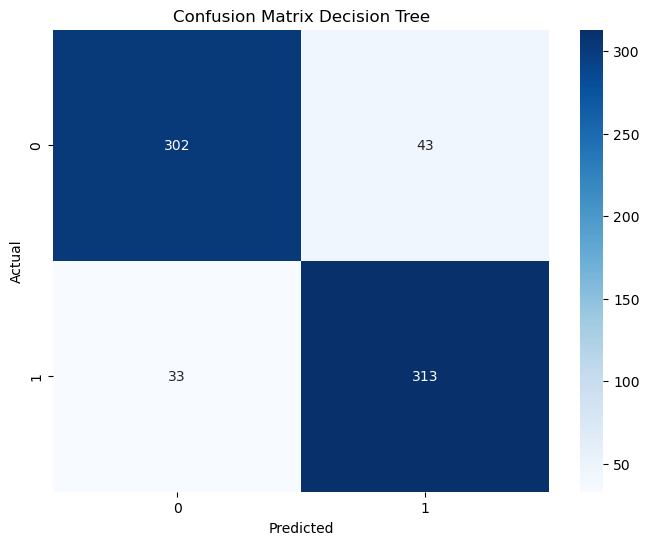

In [16]:
# we again create a new decision tree classifier with the best depth that 
# we found and fit it on our data we set for evaluation
best_depth_classifier = DecisionTreeClassifier(max_depth=best_depth_index, criterion='gini', min_samples_split=100)
best_depth_classifier.fit(X_train_full, y_train_full)  
y_test_pred_dtc = best_depth_classifier.predict(X_test_full)
x_dtc = y_test_full
# we then create the confusion matrix given predictions and correct labels.
conf_matrix_dtc = confusion_matrix(y_test_full, y_test_pred_dtc)
print("Confusion Matrix Decision Tree")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dtc, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Decision Tree')
plt.show()

# 16

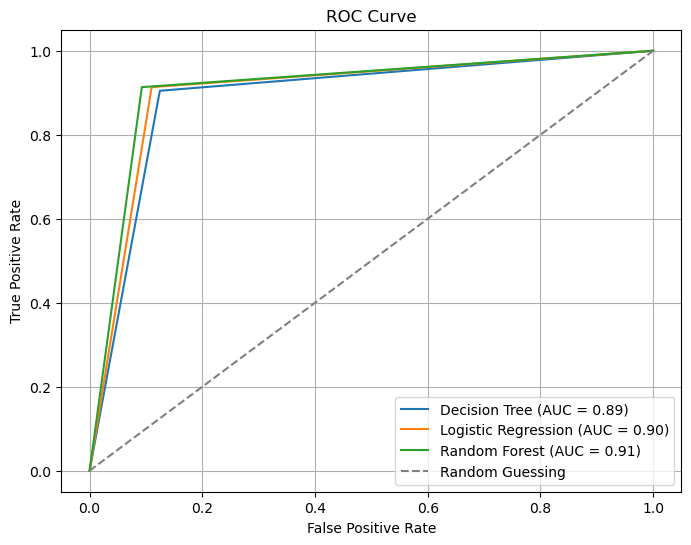

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import LabelEncoder
# we define a labelencoder here to transfer the output label that we had reserved using the test split
# for each single model. We deliberately used a labelencoder instead of one-hot-encoding as a we only have 
# two labels which can easily be transformed into binary data such that we don't need to deal with extra created
# columns for each variable permutation.
le = LabelEncoder()
charges_column_encoded_dtc = copy.copy(x_dtc)
charges_column_encoded_dtc = le.fit_transform(charges_column_encoded_dtc)
charges_column_encoded_logistic = copy.copy(x_logistic)
charges_column_encoded_logistic = le.fit_transform(charges_column_encoded_logistic)
charges_column_encoded_rfc = copy.copy(x_rfc)
charges_column_encoded_rfc = le.fit_transform(charges_column_encoded_rfc)
# once we encoded all columns we create lists containing the correct output columns of each model together with
# the predictions of each model such that we can use it to create a ROC curve given the TPR and FPR
all_y_preds = [y_test_pred_dtc, y_test_pred_log_reg, y_test_pred_rfc]
all_y_true = [charges_column_encoded_dtc, charges_column_encoded_logistic, charges_column_encoded_rfc]
all_labels = ['Decision Tree', 'Logistic Regression', 'Random Forest']

plt.figure(figsize=(8, 6))
# we use zip to create a 3-tuple for each model that we used and create the roc curve in the same figure
# that we defined such that comparing is easier. We then eventually also calculate the auc for each model
# in the form of a float with 2 decimals
for y_preds, y_true, label in zip(all_y_preds, all_y_true, all_labels):
    y_preds = le.fit_transform(y_preds)
    fpr, tpr, _ = roc_curve(y_true, y_preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# 17

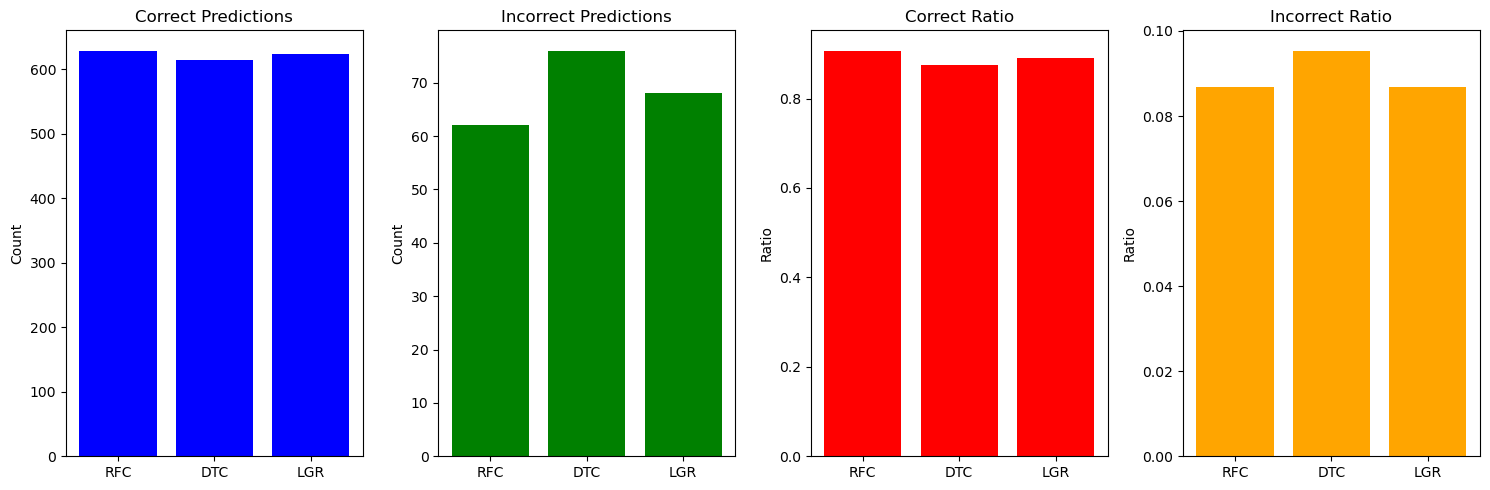

In [18]:
import matplotlib.pyplot as plt
# we initialize the confusion matrices for each model.
algo_names = ["RFC", "DTC", "LGR"]
algo_matrices = [conf_matrix_rfc, conf_matrix_dtc, conf_matrix_logistic]
# we also set the lists with values to null
correct_values = []
incorrect_values = []
correct_ratio_values = []
incorrect_ratio_values = []
# for each algorithm, we will compute the ratio's and values given the confusion matrix.
# we then append those values to the lists
for i in range(len(algo_names)):
    correct = algo_matrices[i][0][0] + algo_matrices[i][1][1]
    incorrect = algo_matrices[i][0][1] + algo_matrices[i][1][0]
    correct_ratio = algo_matrices[i][0][0] / (algo_matrices[i][0][0] + algo_matrices[i][0][1])
    incorrect_ratio = algo_matrices[i][1][0] / (algo_matrices[i][1][0] + algo_matrices[i][1][1])

    correct_values.append(correct)
    incorrect_values.append(incorrect)
    correct_ratio_values.append(correct_ratio)
    incorrect_ratio_values.append(incorrect_ratio)

f, ax = plt.subplots(1, 4, figsize=(15, 5))
# we then create histograms/barplots for each of the given lists above.
ax[0].bar(algo_names, correct_values, color='blue')
ax[0].set_title('Correct Predictions')
ax[0].set_ylabel('Count')

ax[1].bar(algo_names, incorrect_values, color='green')
ax[1].set_title('Incorrect Predictions')
ax[1].set_ylabel('Count')

ax[2].bar(algo_names, correct_ratio_values, color='red')
ax[2].set_title('Correct Ratio')
ax[2].set_ylabel('Ratio')

ax[3].bar(algo_names, incorrect_ratio_values, color='orange')
ax[3].set_title('Incorrect Ratio')
ax[3].set_ylabel('Ratio')

plt.tight_layout()
plt.show()
